In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Select predictions file

In [2]:
for ppath in os.listdir('../../Downloads/'):
    if 'predictions' in ppath:
        print(ppath)

predictions_frame_5epoch_095009_02-08.npy
predictions_o_missingvids_minorimbalance_5epochs_224638_02-20.npy
predictions_s0.5_missingvids_minorimbalance_5epochs_230857_03-02.npy
predictions_s1_missingvids_minorimbalance_5epochs_152550_02-27.npy
predictions_s2_missingvids_minorimbalance_5epochs_181615_03-01.npy


In [3]:
# change this to a path to .npy file
path = '../../Downloads/predictions_s1_missingvids_minorimbalance_5epochs_152550_02-27.npy'
preds1 = np.load(path)

# change this to a path to .npy file
path = '../../Downloads/predictions_o_missingvids_minorimbalance_5epochs_224638_02-20.npy'
preds2 = np.load(path)

# change this to a path to .npy file
path = '../../Downloads/predictions_s2_missingvids_minorimbalance_5epochs_181615_03-01.npy'
preds3 = np.load(path)

# change this to a path to .npy file
path = '../../Downloads/predictions_s0.5_missingvids_minorimbalance_5epochs_230857_03-02.npy'
preds4 = np.load(path)

# Process individual filtered image predictions

In [4]:
probs_fi1 = np.array([float(p) for p in preds1[:, 2]])
y_fi1 = np.array([int(float('nystagmus' in l)) for l in preds1[:,0]])

fpr1, tpr1, thresh1 = roc_curve(y_fi1, probs_fi1, pos_label=1)
random_probs = [0 for i in range(len(y_fi1))]
p_fpr, p_tpr, _ = roc_curve(y_fi1, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_fi1, probs_fi1)
print('AUC 1 = ', auc_score1)

probs_fi2 = np.array([float(p) for p in preds2[:, 2]])
y_fi2 = np.array([int(float('nystagmus' in l)) for l in preds2[:,0]])

fpr2, tpr2, thresh2 = roc_curve(y_fi2, probs_fi2, pos_label=1)
auc_score2 = roc_auc_score(y_fi2, probs_fi2)
print('AUC 2= ', auc_score2)

probs_fi3 = np.array([float(p) for p in preds3[:, 2]])
y_fi3 = np.array([int(float('nystagmus' in l)) for l in preds3[:,0]])

fpr3, tpr3, thresh3 = roc_curve(y_fi3, probs_fi3, pos_label=1)
auc_score3 = roc_auc_score(y_fi3, probs_fi3)
print('AUC 3= ', auc_score3)

probs_fi4 = np.array([float(p) for p in preds4[:, 2]])
y_fi4 = np.array([int(float('nystagmus' in l)) for l in preds4[:,0]])

fpr4, tpr4, thresh4 = roc_curve(y_fi4, probs_fi4, pos_label=1)
auc_score4 = roc_auc_score(y_fi4, probs_fi4)
print('AUC 4= ', auc_score4)

AUC 1 =  0.7966424699199737
AUC 2=  0.8136437371312709
AUC 3=  0.7997362597296962
AUC 4=  0.7808292693015901


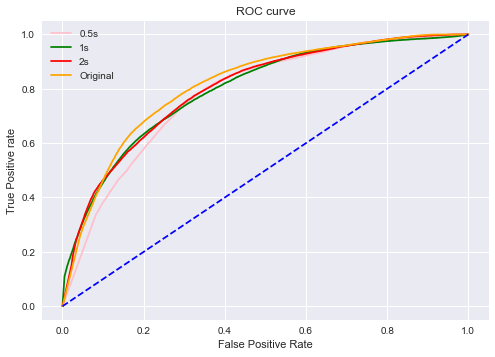

In [5]:
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr4, tpr4, linestyle='-',color='pink', label='0.5s')
plt.plot(fpr1, tpr1, linestyle='-',color='green', label='1s')
plt.plot(fpr3, tpr3, linestyle='-',color='red', label='2s')
plt.plot(fpr2, tpr2, linestyle='-',color='orange', label='Original')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

In [6]:
optimal_thresh1 = thresh1[np.argmax(tpr1-fpr1)]
print('Optimal Threshold1 = ',round(optimal_thresh1*100,2),'%')
optimal_thresh2 = thresh2[np.argmax(tpr2-fpr2)]
print('Optimal Threshold2 = ',round(optimal_thresh2*100,2),'%')
optimal_thresh3 = thresh3[np.argmax(tpr3-fpr3)]
print('Optimal Threshold3 = ',round(optimal_thresh3*100,2),'%')
optimal_thresh4 = thresh4[np.argmax(tpr4-fpr4)]
print('Optimal Threshold4 = ',round(optimal_thresh4*100,2),'%')
optimal_thresh1, optimal_thresh2, optimal_thresh3, optimal_thresh4

Optimal Threshold1 =  59.13 %
Optimal Threshold2 =  32.49 %
Optimal Threshold3 =  5.66 %
Optimal Threshold4 =  47.36 %


(0.5912518, 0.32487783, 0.056587666, 0.47360393)

# Process video level predictions

In [7]:
def getyp(preds, optimal_thresh):
    # this is a dictionary that stores predictions
    # key = video name
    # value = [count of filtered images above threshold, count of filtered images per video, true label of 0 or 1 (normal or nystagmus)]
    vids_dict = dict()
    for pred in preds:
        name = pred[0].split('/')[1].split('.')[0]
        name = name.split('-')[0] + name.split('-')[1]
        prob = float(pred[2])
        try:
            p, c, label = vids_dict[name]
            p += 1 if prob >= optimal_thresh else 0
            c += 1
            vids_dict[name] = (p, c, label)
        except:
            #p = prob
            p = 1 if prob >= optimal_thresh else 0
            c = 1
            label = int(float('nystagmus' in pred[0]))
            vids_dict[name] = (p,c,label)
    # this function calculates a list of probabilities of nystagmus for each video
    # vid_dict.keys(), y, probs are in same order (print to view)

    y = []
    probs = []
    for key in vids_dict.keys():
        p, c, label = vids_dict[key]
        y.append(label)
        prob = float(p)/float(c)
        probs.append(prob)
    y = np.array(y) # true labels
    probs = np.array(probs) # predicted probabilities of nystagmus
    return y, probs

In [8]:
y1, probs1 = getyp(preds1, optimal_thresh1)
y2, probs2 = getyp(preds2, optimal_thresh2)
y3, probs3 = getyp(preds3, optimal_thresh3)
y4, probs4 = getyp(preds4, optimal_thresh4)

# METRICS

In [9]:
fpr1, tpr1, thresh1 = roc_curve(y1, probs1, pos_label=1)
random_probs = [0 for i in range(len(y1))]
p_fpr, p_tpr, _ = roc_curve(y1, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y1, probs1)
print('AUC 1 = ', auc_score1)

fpr2, tpr2, thresh2 = roc_curve(y2, probs2, pos_label=1)
auc_score2 = roc_auc_score(y2, probs2)
print('AUC 2 = ', auc_score2)

fpr3, tpr3, thresh3 = roc_curve(y3, probs3, pos_label=1)
auc_score3 = roc_auc_score(y3, probs3)
print('AUC 3 = ', auc_score3)

fpr4, tpr4, thresh4 = roc_curve(y4, probs4, pos_label=1)
auc_score4 = roc_auc_score(y4, probs4)
print('AUC 4 = ', auc_score4)

AUC 1 =  0.8108322026232473
AUC 2 =  0.8531207598371777
AUC 3 =  0.8221393034825871
AUC 4 =  0.8158073270013569


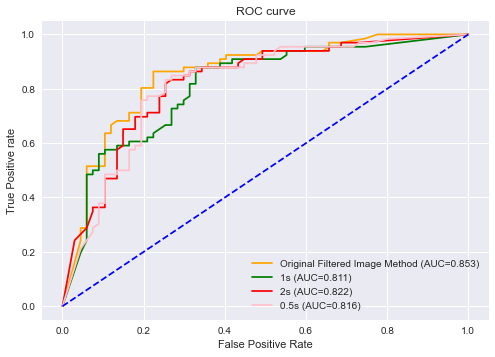

In [10]:
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr2, tpr2, linestyle='-',color='orange', label='Original Filtered Image Method (AUC='+str(round(auc_score2,3))+')')
plt.plot(fpr1, tpr1, linestyle='-',color='green', label='1s (AUC='+str(round(auc_score1,3))+')')
plt.plot(fpr3, tpr3, linestyle='-',color='red', label='2s (AUC='+str(round(auc_score3,3))+')')
plt.plot(fpr4, tpr4, linestyle='-',color='pink', label='0.5s (AUC='+str(round(auc_score4,3))+')')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

In [17]:
optimal_thresh = thresh3[np.argmax(tpr3-fpr3)]
print('Optimal Threshold = ',round(optimal_thresh*100,2),'%')

Optimal Threshold =  52.39 %


In [18]:
preds = np.array([int(float(p)) for p in (probs3 >= optimal_thresh)])

In [20]:
conf_matrix = confusion_matrix(y3, preds)
print('Confusion Matrix')
conf_matrix

Confusion Matrix


array([[49, 18],
       [11, 55]], dtype=int64)

In [21]:
acc = accuracy_score(y3, preds)
print('Accuracy = ', acc)

Accuracy =  0.7819548872180451


In [22]:
tn, fp, fn, tp = conf_matrix.ravel()
tn, fp, fn, tp

(49, 18, 11, 55)

In [23]:
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(fn+tn)

print('Sensitivity = ', sensitivity)
print('Specificity = ', specificity)
print('PPV = ', ppv)
print('NPV = ', npv)

Sensitivity =  0.8333333333333334
Specificity =  0.7313432835820896
PPV =  0.7534246575342466
NPV =  0.8166666666666667


In [37]:
sens = []
spec = []
ppvs = []
npvs = []
accs = []
ths = []
intersect_thresh = 0
for t,f,th in zip(tpr,fpr,thresh[1:]):
    try:
        preds_i = np.array([int(float(p)) for p in (probs >= th)])
        conf_matrix_i = confusion_matrix(y, preds_i)
        acc_i = accuracy_score(y, preds_i)
        tn, fp, fn, tp = conf_matrix_i.ravel()
        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        ppv = tp/(tp+fp)
        npv = tn/(fn+tn)
        if ppv == npv or npv == sensitivity or sensitivity==specificity or specificity==ppv: intersect_thresh=th
        sens.append(sensitivity)
        spec.append(specificity)
        ppvs.append(ppv)
        npvs.append(npv)
        accs.append(acc_i)
        ths.append(th)
    except:
        continue

<ipython-input-37-40d6815467e2>:17: RuntimeWarning: invalid value encountered in longlong_scalars
  npv = tn/(fn+tn)


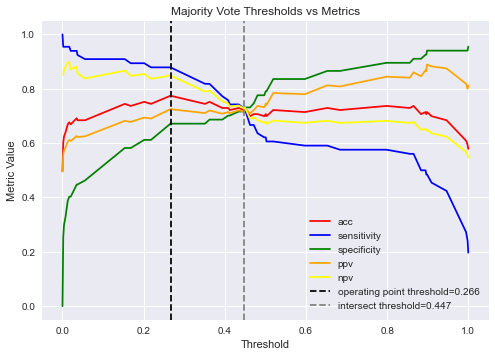

In [44]:
plt.plot(ths,accs, color='red', label='acc')
plt.plot(ths,sens, color='blue', label='sensitivity')
plt.plot(ths,spec, color='green', label='specificity')
plt.plot(ths,ppvs, color='orange', label='ppv')
plt.plot(ths,npvs, color='yellow', label='npv')
plt.axvline(x=optimal_thresh, label='operating point threshold='+str(round(optimal_thresh,3)), color='black', linestyle='--')
plt.axvline(x=intersect_thresh, label='intersect threshold='+str(round(intersect_thresh,3)), color='gray', linestyle='--')
plt.legend(loc='lower right')
plt.title('Majority Vote Thresholds vs Metrics')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.show()